# Lab Assignment 2 - Part C: Naive Bayes for Spam Detection
Please refer to the `README.pdf` for full laboratory instructions.


## Problem Statement
In this part, you will implement a **Naive Bayes classifier** for spam email detection using the Spambase dataset.

### Dataset Description
The Spambase dataset contains 4601 email samples with 57 features:
- **Features 1-48**: Word frequencies (percentage of words matching specific words)
- **Features 49-54**: Character frequencies (`;`, `(`, `[`, `!`, `$`, `#`)
- **Features 55-57**: Capital letter statistics
- **Label**: 1 = spam, 0 = not spam

### Your Tasks
1. **Implement Gaussian Naive Bayes** from scratch
2. **Train and evaluate** your classifier (accuracy, precision, recall, F1-score)
3. **Feature analysis**: Identify top discriminative features
4. **Discussion**: Why does Naive Bayes work for spam detection?


## Setup


In [1]:
%pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library declarations
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


## Load the Spambase Dataset


In [4]:
# Fetch Spambase dataset from UCI ML Repository
spambase = fetch_ucirepo(id=94)

# Get features and labels
X = spambase.data.features.values
y = spambase.data.targets.values.ravel()

print(f"Dataset shape: {X.shape}")
print(f"Number of spam emails: {np.sum(y == 1)}")
print(f"Number of non-spam emails: {np.sum(y == 0)}")
print(f"\nFeature names: {list(spambase.data.features.columns[:10])}...")  # First 10 features


Dataset shape: (4601, 57)
Number of spam emails: 1813
Number of non-spam emails: 2788

Feature names: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail']...


In [5]:
# Split data into training (80%) and testing (20%) sets
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    np.random.seed(random_state)
    n_samples = len(y)
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 3681 samples
Testing set: 920 samples


## Task 1: Implement Gaussian Naive Bayes
Implement a Gaussian Naive Bayes classifier from scratch.

**Key formulas:**
- Class prior: $P(C) = \frac{N_C}{N}$
- Gaussian likelihood: $P(x_i|C) = \frac{1}{\sqrt{2\pi\sigma_{i,C}^2}} \exp\left(-\frac{(x_i - \mu_{i,C})^2}{2\sigma_{i,C}^2}\right)$
- Use **log-probabilities** to avoid numerical underflow!


In [6]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None      # P(C) for each class
        self.means = None       # Mean of each feature per class
        self.variances = None   # Variance of each feature per class
    
    def fit(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        y : numpy array of shape (n_samples,)
        """
        # TODO: Implement training
        # 1. Get unique classes
        # 2. Calculate class priors P(C)
        # 3. Calculate mean and variance for each feature per class
        # Hint: Add a small epsilon to variance to avoid division by zero
        
        #finds shapes/ number of columns and rows
        n_samples, n_features= X.shape
        
        # 1. Get unique classes
        self.classes= np.unique(y)
        n_classes= len(self.classes)

        #Initialize arrays to store smeans and variances of all statistics
        self.means=np.zeros((n_classes, n_features))
        self.variances= np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        # 2. Calculate class priors P(C)

        #compute mean and variances of each class
        for idx, c in enumerate(self.classes):
            # Get all samples belonging to class c
            X_c = X[y == c]
            
            #compute the class prior P(C)
            self.priors[idx] = X_c.shape[0] / n_samples
            
        # 3. Calculate mean and variance for each feature per class
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0)
        
        # Hint: Add a small epsilon to variance to avoid division by zero
        self.variances += 1e-9

    
    def _gaussian_log_likelihood(self, x, mean, var):
        """
        Calculate log of Gaussian probability density.
        
        Returns:
        --------
        log_likelihood : float
        """
        # TODO: Implement log of Gaussian PDF

        # log P(x|C) = -0.5 * log(2*pi*var) - 0.5 * (x - mean)^2 / var
        log_likelihood = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2) / var
        return log_likelihood
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        
        Returns:
        --------
        predictions : numpy array of shape (n_samples,)
        """
        # TODO: Implement prediction
        # For each sample:
        #   1. Calculate log P(C) + sum of log P(x_i|C) for each class
        #   2. Return the class with highest log probability
        
        #   1. Calculate log P(C) + sum of log P(x_i|C) for each class
        predictions = []
        
        for x in X:
            #Calculate log probability for each class and store it in this empty array
            log_probs= []
            
            #cite: I got the enumerate function from https://www.geeksforgeeks.org/python/enumerate-in-python/
            for idx, c in enumerate(self.classes):
                #for each class, find the log posterior score
                log_prob = np.log(self.priors[idx])
                #and then add log likelihood for each feature and sum them
                log_prob += np.sum(self._gaussian_log_likelihood(x, self.means[idx, :], self.variances[idx, :]))
                #add it to the list
                log_probs.append(log_prob)
            
            #like we saw in class, argmax fins the index of the max score. so we return the class with highest log probability
            predictions.append(self.classes[np.argmax(log_probs)])
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Return probability estimates for samples.
        
        Returns:
        --------
        probabilities : numpy array of shape (n_samples, n_classes)
        """
        # TODO: (Optional) Implement probability estimation
        probabilities = []
        
        for x in X:
            log_probs = []
            
            #sorts through each class
            for idx, c in enumerate(self.classes):
                #starting with log prior
                log_prob = np.log(self.priors[idx])
                #add the log likelihood to the features
                log_prob += np.sum(self._gaussian_log_likelihood(x, self.means[idx, :], self.variances[idx, :]))
                #append the array
                log_probs.append(log_prob)
            
            #convert these log probabilities back to real probabilities
            log_probs= np.array(log_probs)
            max_log_prob= np.max(log_probs)

            #shift values by max_log_prob so exponentials stay numerically safe. Cite: I used Chat GPT to debug this!
            exp_probs= np.exp(log_probs - max_log_prob)
            probs= exp_probs / np.sum(exp_probs)
            
            #append the array
            probabilities.append(probs)
        
        return np.array(probabilities)


## Task 2: Train and Evaluate
Train your classifier and compute evaluation metrics.


In [8]:
def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics.
    
    Returns:
    --------
    accuracy, precision, recall, f1_score : floats
    """
    # TODO: Implement metrics computation
    #Accuracy = (TP + TN) / (TP + TN + FP + FN)
    #Precision = TP / (TP + FP)
    #Recall = TP / (TP + FN)
    #F1 = 2 * (Precision * Recall) / (Precision + Recall)

    #finding true positive, false positives, true negatives, and False Negatives
    TP= np.sum((y_true == 1) & (y_pred == 1))
    TN= np.sum((y_true == 0) & (y_pred == 0))
    FP= np.sum((y_true == 0) & (y_pred == 1))
    FN= np.sum((y_true == 1) & (y_pred == 0))
    
    #equation for accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    #equation for precision, dont divide by 0 for all stable numbers
    if (TP + FP) == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)
    
    #equation for recall given
    if (TP + FN) == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)
    
    #F1 score equation
    if (precision + recall) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score
    


def confusion_matrix(y_true, y_pred):
    """
    Create confusion matrix.
    
    Returns:
    --------
    matrix : numpy array of shape (2, 2)
        [[TN, FP], [FN, TP]]
    """
    # TODO: Implement confusion matrix

    #I don't know if we need to state this again? But I did just in case since it is different functions
    #finding true positive, false positives, true negatives, and False Negatives
    TP= np.sum((y_true == 1) & (y_pred == 1))
    TN= np.sum((y_true == 0) & (y_pred == 0))
    FP= np.sum((y_true == 0) & (y_pred == 1))
    FN= np.sum((y_true == 1) & (y_pred == 0))

    #return the matrix!

    matrix= np.array([[TN, FP], [FN, TP]])

    return matrix


## Task 3: Feature Analysis
Identify the most discriminative features for spam detection.


In [10]:
# TODO: Train your classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)

# TODO: Make predictions
y_pred = nb_classifier.predict(X_test)

# TODO: Compute and print metrics
accuracy, precision, recall, f1 = compute_metrics(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# TODO: Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)


Accuracy: 0.8217
Precision: 0.7233
Recall: 0.9385
F1-Score: 0.8170

Confusion Matrix:
[[390 140]
 [ 24 366]]


In [11]:
# TODO: Identify top 5 most discriminative features
# Hint: You can measure discriminative power by:
# - Difference in means between classes (normalized by pooled std)
# - Or by feature importance based on model weights

feature_names= list(spambase.data.features.columns)

# TODO: Calculate discriminative score for each feature
discriminative_scores = []
for i in range(X.shape[1]):
     #splits data into two groups, so its labeled spam if y==1
     spam_values= X[y==1, i]
     not_spam_values= X[y==0,i]

     #computes average value of feature for each class, so if the means are far apart it likely helps distinguish spam vs not spam
     mean_spam= np.mean(spam_values)
     mean_not_spam=np.mean(not_spam_values)

     #finds standard deviation
     std_spam = np.std(spam_values)
     std_not_spam= np.std(not_spam_values)
     pooled_std= np.sqrt((std_spam**2 + std_not_spam**2) / 2)
    
    #for real numbers
     if pooled_std < 1e-10:
        pooled_std = 1e-10
    
    #compute discriminitive score and add it to array
     score = abs(mean_spam - mean_not_spam) / pooled_std
     discriminative_scores.append(score)

# convert to lib array
discriminative_scores = np.array(discriminative_scores)

# TODO: Get top 5 features
top_5_indices = np.argsort(discriminative_scores)[-5:][::-1]
print("Top 5 most discriminative features:")
for idx in top_5_indices:
     print(f"  {feature_names[idx]}: score = ...")


Top 5 most discriminative features:
  word_freq_your: score = ...
  word_freq_000: score = ...
  word_freq_remove: score = ...
  char_freq_$: score = ...
  word_freq_hp: score = ...


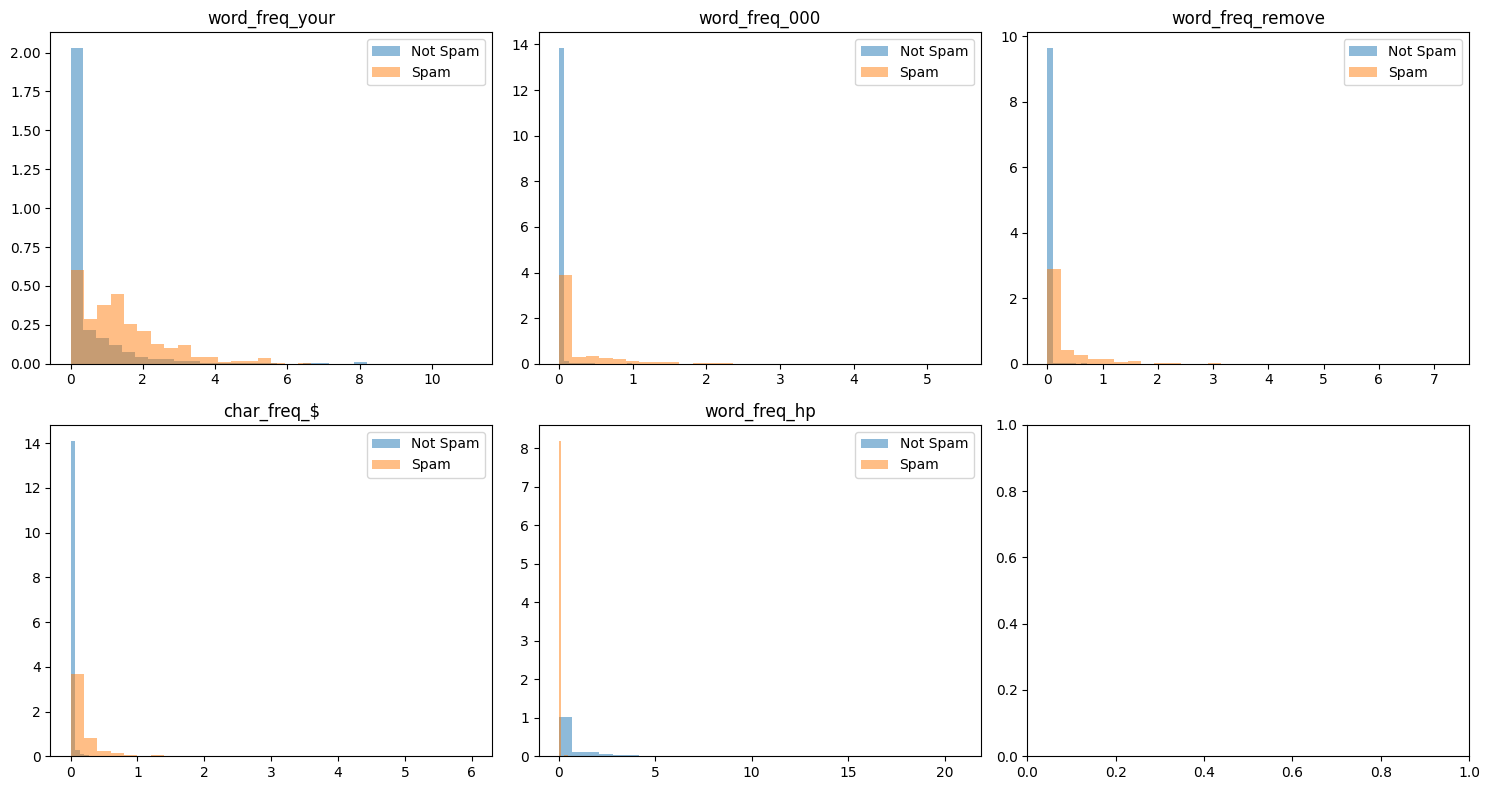

In [12]:
# TODO: Visualize distributions of top features for spam vs non-spam
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, idx in enumerate(top_5_indices[:5]):
     ax = axes[i // 3, i % 3]
     ax.hist(X[y == 0, idx], bins=30, alpha=0.5, label='Not Spam', density=True)
     ax.hist(X[y == 1, idx], bins=30, alpha=0.5, label='Spam', density=True)
     ax.set_title(f'{feature_names[idx]}')
     ax.legend()
plt.tight_layout()
plt.show()


## Summary and Discussion

### Results Table
| Metric | Value |
|--------|-------|
| Accuracy | ? |
| Precision | ? |
| Recall | ? |
| F1-Score | ? |

### Top 5 Discriminative Features
1. ?
2. ?
3. ?
4. ?
5. ?

### Discussion
*Answer these questions:*
1. Why is Naive Bayes effective for spam detection despite the independence assumption?
2. What are the limitations of your implementation?
3. How could you improve the classifier?
4. What did you learn from this exercise?
